# Importer le modèle Word2Vec

In [2]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import word2vec

random.seed(1)
np.random.seed(1)

In [3]:
os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

In [11]:
nom_dossier = 'ens'
dim = 50
# dim = 300
# dim = 100
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

In [12]:
matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

matrice_norm = {word : normalize(matrice[word]) for word in matrice.keys()}

## On importe les données de train et on calcule le "sentence-embedding"

In [6]:
# Si on veut récup les fichiers
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train.file", "rb") as f:
    corpus_train = pickle.load(f)

In [7]:
def calcul_sentence_embedding(phrase):
    if len(phrase)>0:
        sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
        #sum1 = sum(matrice_norm[mot] for mot in phrase if mot in model1.wv.index2word)
        sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
        #sum2 = sum(matrice_norm["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
        return (sum1+sum2)/len(phrase)
    else:
        return matrice["lowfrequencyword"]

In [45]:
phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]

In [46]:
phrases_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases]

In [47]:
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]

In [48]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
reg_log = lr.fit(X_train,Y_train)

In [49]:
Y_train_pred = reg_log.predict(X_train)

from sklearn import metrics
# Matrice confusion
cm = metrics.confusion_matrix(Y_train,Y_train_pred)
print(cm)
# Accuracy
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

[[17596  7404]
 [ 8022 16978]]
0.69148


In [50]:
phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
phrases_test_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log.predict(X_test)

In [51]:
# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

[[1424  560]
 [ 671 1327]]
0.6908588648920141


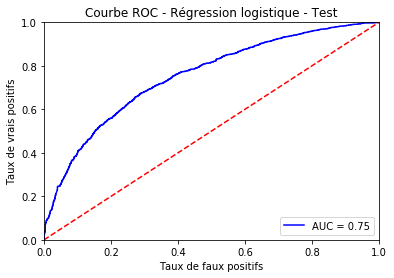

In [52]:
# Essai courbe ROC
import sklearn.metrics as metrics
probs = reg_log.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Courbe ROC - Régression logistique - Test')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

## Pourquoi ce score ?

In [15]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
n = 0
absents = []
for word in vocabulaire:
    if word not in model1.wv.index2word:
        n+=1
        absents.append(word)
print(n)
print(len(vocabulaire))

21204
39650


In [16]:
n/len(vocabulaire)

0.5347793190416141

## Stopwords

In [17]:
import nltk
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('french'))

In [18]:
def suppr_stop(phrase):
    return [mot for mot in phrase if mot not in stop_words]
    
phrases_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_train]

In [53]:
print(phrases[0])
print(phrases_stop[0])

[['est', 'très', 'heureux', 'que', 'aujourdhui', 'marque', '6', 'merveilleux', 'mois', 'avec', 'stephanie'], 1]
[['très', 'heureux', 'aujourdhui', 'marque', '6', 'merveilleux', 'mois', 'stephanie'], 1]


In [54]:
phrases_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_stop]
Y_train_stop = [score for (score, embedding) in phrases_emb_stop]
X_train_stop = [embedding for (score, embedding) in phrases_emb_stop]

In [55]:
lr_stop = LogisticRegression()
reg_log_st = lr_stop.fit(X_train_stop,Y_train_stop)

C:\Users\torna\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [58]:
Y_train_pred_stop = reg_log_st.predict(X_train_stop)

# Matrice confusion
cm_stop = metrics.confusion_matrix(Y_train_stop,Y_train_pred_stop)
print(cm_stop)
# Accuracy
acc_stop = metrics.accuracy_score(Y_train_stop,Y_train_pred_stop)
print(acc_stop) 


phrases_test_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_test]
phrases_test_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test_stop]
Y_test_stop = [score for (score, embedding) in phrases_test_emb_stop]
X_test_stop = [embedding for (score, embedding) in phrases_test_emb_stop]
Y_test_pred_stop = reg_log_st.predict(X_test_stop)

# Matrice confusion
cm_test_stop = metrics.confusion_matrix(Y_test_stop,Y_test_pred_stop)
print(cm_test_stop)
# Accuracy
acc_test_stop = metrics.accuracy_score(Y_test_stop,Y_test_pred_stop)
print(acc_test_stop) 

[[16955  8045]
 [ 8239 16761]]
0.67432
[[1357  627]
 [ 685 1313]]
0.6705173279758915


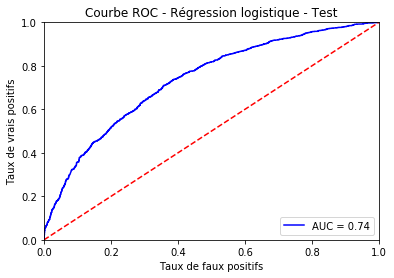

In [59]:
# Essai courbe ROC
probs_stop = reg_log_st.predict_proba(X_test_stop)
preds_stop = probs_stop[:,1]
fpr_stop, tpr_stop, threshold_stop = metrics.roc_curve(Y_test_stop, preds_stop)
roc_auc_stop = metrics.auc(fpr_stop, tpr_stop)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Courbe ROC - Régression logistique - Test')
plt.plot(fpr_stop, tpr_stop, 'b', label = 'AUC = %0.2f' % roc_auc_stop)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

In [60]:
# On sauve les modèles
with open("data/sentimental_analysis/reg_log_100_norm.file", "wb") as f:
    pickle.dump(reg_log, f, pickle.HIGHEST_PROTOCOL)
with open("data/sentimental_analysis/reg_log_st_100_norm.file", "wb") as f:
    pickle.dump(reg_log_st, f, pickle.HIGHEST_PROTOCOL)

# Modèle : combiner régression logistique + poids des mots

In [63]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
matrice_sentiments = {mot:(0,0) for mot in vocabulaire}

def sentiment_plus(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)
    
for (score, tweet) in corpus_train:
    for mot in tweet.split():
        if score == 1:
            sentiment_plus(mot)
        else:
            sentiment_moins(mot)
            
matrice_sentiments_val = {mot:(matrice_sentiments[mot][0]-matrice_sentiments[mot][1])/((matrice_sentiments[mot][0]+matrice_sentiments[mot][1]))
                          for mot in vocabulaire}

In [68]:
def calcul_sentence_embedding_pond(phrase):
    if len(phrase)>0:
        #sum1 = sum(matrice[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and mot in vocabulaire)
        #sum2 = sum(matrice["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
        sum1 = sum(matrice_norm[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and
                   mot in vocabulaire)
        sum2 = sum(matrice_norm["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
        return (sum1+sum2)/len(phrase)
    else:
        return matrice["lowfrequencyword"]

print(calcul_sentence_embedding(["le","test"])[0])
print(calcul_sentence_embedding_pond(["gentil"])[0])
print(calcul_sentence_embedding_pond(["méchant"])[0])

0.0022627153
0.002601578
-0.0072481297


In [69]:
phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]
phrases_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases]

In [70]:
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]
lr = LogisticRegression()
reg_log = lr.fit(X_train,Y_train)

Y_train_pred = reg_log.predict(X_train)

from sklearn import metrics
# Matrice confusion
cm = metrics.confusion_matrix(Y_train,Y_train_pred)
print(cm)
# Accuracy
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

[[19120  5880]
 [ 5548 19452]]
0.77144


In [71]:
phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
phrases_test_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log.predict(X_test)
# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

[[1408  576]
 [ 645 1353]]
0.6933701657458563


In [72]:
import nltk
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('french'))

def suppr_stop(phrase):
    return [mot for mot in phrase if mot not in stop_words]
    
phrases_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_train]

phrases_emb_stop = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_stop]
Y_train_stop = [score for (score, embedding) in phrases_emb_stop]
X_train_stop = [embedding for (score, embedding) in phrases_emb_stop]

lr_stop = LogisticRegression()
reg_log_st = lr_stop.fit(X_train_stop,Y_train_stop)

Y_train_pred_stop = reg_log_st.predict(X_train_stop)

# Matrice confusion
cm_stop = metrics.confusion_matrix(Y_train_stop,Y_train_pred_stop)
print(cm_stop)
# Accuracy
acc_stop = metrics.accuracy_score(Y_train_stop,Y_train_pred_stop)
print(acc_stop) 


phrases_test_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_test]
phrases_test_emb_stop = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_test_stop]
Y_test_stop = [score for (score, embedding) in phrases_test_emb_stop]
X_test_stop = [embedding for (score, embedding) in phrases_test_emb_stop]
Y_test_pred_stop = reg_log_st.predict(X_test_stop)

# Matrice confusion
cm_test_stop = metrics.confusion_matrix(Y_test_stop,Y_test_pred_stop)
print(cm_test_stop)
# Accuracy
acc_test_stop = metrics.accuracy_score(Y_test_stop,Y_test_pred_stop)
print(acc_test_stop) 

[[19250  5750]
 [ 5227 19773]]
0.78046
[[1364  620]
 [ 641 1357]]
0.6833249623304872


# Réutiliser modèle

In [9]:
with open("data/sentimental_analysis/reg_log_300.file", "rb") as f:
    reg_log_300 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_st_300.file", "rb") as f:
    reg_log_st_300 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_50.file", "rb") as f:
    reg_log_50 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_st_50.file", "rb") as f:
    reg_log_st_50 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_100.file", "rb") as f:
    reg_log_100 = pickle.load(f)
with open("data/sentimental_analysis/reg_log_st_100.file", "rb") as f:
    reg_log_st_100 = pickle.load(f)

In [43]:
nom_dossier = 'ens'
dim = 50
# dim = 300
# dim = 100
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

In [44]:
matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

matrice_norm = {word : normalize(matrice[word]) for word in matrice.keys()}

In [45]:
from sklearn.linear_model import LogisticRegression

def calcul_sentence_embedding(phrase):
    if len(phrase)>0:
        #sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
        sum1 = sum(matrice_norm[mot] for mot in phrase if mot in model1.wv.index2word)
        #sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
        sum2 = sum(matrice_norm["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
        return (sum1+sum2)/len(phrase)
    else:
        return matrice["lowfrequencyword"]
    
phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]
phrases_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases]
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]

lr = LogisticRegression()
reg_log_50_norm = lr.fit(X_train,Y_train)

Y_train_pred = reg_log_50_norm.predict(X_train)

phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
phrases_test_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log_50_norm.predict(X_test)

from sklearn import metrics
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

0.68322
0.6722752385735811


In [46]:
probs50_norm = reg_log_50_norm.predict_proba(X_test)
preds50_norm = probs50_norm[:,1]
fpr50_norm, tpr50_norm, threshold50_norm = metrics.roc_curve(Y_test, preds50_norm)
roc_auc50_norm = metrics.auc(fpr50_norm, tpr50_norm)

In [49]:
nom_dossier = 'ens'
dim = 100
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}


matrice_norm = {word : normalize(matrice[word]) for word in matrice.keys()}

In [50]:
phrases_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases]
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]
lr = LogisticRegression()
reg_log_100_norm = lr.fit(X_train,Y_train)

Y_train_pred = reg_log_100_norm.predict(X_train)

phrases_test_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log_100_norm.predict(X_test)

from sklearn import metrics
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

probs100_norm = reg_log_100_norm.predict_proba(X_test)
preds100_norm = probs100_norm[:,1]
fpr100_norm, tpr100_norm, threshold100 = metrics.roc_curve(Y_test, preds100_norm)
roc_auc100_norm = metrics.auc(fpr100_norm, tpr100_norm)

0.69148
0.6908588648920141


In [51]:
nom_dossier = 'ens'
dim = 300
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

matrice_norm = {word : normalize(matrice[word]) for word in matrice.keys()}

In [52]:
phrases_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases]
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]
lr = LogisticRegression()
reg_log_300_norm = lr.fit(X_train,Y_train)

Y_train_pred = reg_log_300_norm.predict(X_train)

phrases_test_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log_300_norm.predict(X_test)

from sklearn import metrics
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

probs300_norm = reg_log_300_norm.predict_proba(X_test)
preds300_norm = probs300_norm[:,1]
fpr300_norm, tpr300_norm, threshold300_norm = metrics.roc_curve(Y_test, preds300_norm)
roc_auc300_norm = metrics.auc(fpr300_norm, tpr300)

0.71492
0.7049221496735308


ValueError: Found input variables with inconsistent numbers of samples: [1562, 1511]

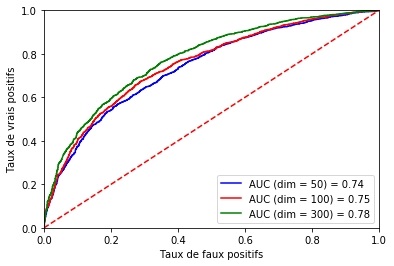

In [53]:
import matplotlib.pyplot as plt
plt.plot(fpr50_norm, tpr50_norm, 'b', label = 'AUC (dim = 50) = %0.2f' % roc_auc50)
plt.plot(fpr100_norm, tpr100_norm, 'r', label = 'AUC (dim = 100) = %0.2f' % roc_auc100)
plt.plot(fpr300_norm, tpr300_norm, 'g', label = 'AUC (dim = 300) = %0.2f' % roc_auc300)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

In [ ]:
# On sauve les modèles norm
with open("data/sentimental_analysis/reg_log_100_norm.file", "wb") as f:
    pickle.dump(reg_log_100_norm, f, pickle.HIGHEST_PROTOCOL)
with open("data/sentimental_analysis/reg_log_50_norm.file", "wb") as f:
    pickle.dump(reg_log_50_norm, f, pickle.HIGHEST_PROTOCOL)
with open("data/sentimental_analysis/reg_log_300_norm.file", "wb") as f:
    pickle.dump(reg_log_300_norm, f, pickle.HIGHEST_PROTOCOL)

# Avec stop-words

In [25]:
import nltk
from nltk.corpus import stopwords
stop_words =  set(stopwords.words('french'))
def suppr_stop(phrase):
    return [mot for mot in phrase if mot not in stop_words]
    
phrases_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_train]
phrases_test_stop = [[suppr_stop(tweet.split()),score] for (score, tweet) in corpus_test]

In [29]:
nom_dossier = 'ens'
dim = 50
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

In [30]:
phrases_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_stop]
Y_train_stop = [score for (score, embedding) in phrases_emb_stop]
X_train_stop = [embedding for (score, embedding) in phrases_emb_stop]
Y_train_pred_stop = reg_log_st_50.predict(X_train_stop)

acc_stop = metrics.accuracy_score(Y_train_stop,Y_train_pred_stop)
print(acc_stop) 

phrases_test_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test_stop]
Y_test_stop = [score for (score, embedding) in phrases_test_emb_stop]
X_test_stop = [embedding for (score, embedding) in phrases_test_emb_stop]
Y_test_pred_stop = reg_log_st_50.predict(X_test_stop)

acc_test_stop = metrics.accuracy_score(Y_test_stop,Y_test_pred_stop)
print(acc_test_stop) 

probs50_st = reg_log_st_50.predict_proba(X_test_stop)
preds50_st = probs50_st[:,1]
fpr50_st, tpr50_st, threshold50_st = metrics.roc_curve(Y_test_stop, preds50_st)
roc_auc50_st = metrics.auc(fpr50_st, tpr50_st)

0.6642
0.6584630838774486


In [31]:
dim = 100
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

In [32]:
phrases_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_stop]
Y_train_stop = [score for (score, embedding) in phrases_emb_stop]
X_train_stop = [embedding for (score, embedding) in phrases_emb_stop]
Y_train_pred_stop = reg_log_st_100.predict(X_train_stop)

acc_stop = metrics.accuracy_score(Y_train_stop,Y_train_pred_stop)
print(acc_stop) 

phrases_test_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test_stop]
Y_test_stop = [score for (score, embedding) in phrases_test_emb_stop]
X_test_stop = [embedding for (score, embedding) in phrases_test_emb_stop]
Y_test_pred_stop = reg_log_st_100.predict(X_test_stop)

acc_test_stop = metrics.accuracy_score(Y_test_stop,Y_test_pred_stop)
print(acc_test_stop) 

probs100_st = reg_log_st_100.predict_proba(X_test_stop)
preds100_st = probs100_st[:,1]
fpr100_st, tpr100_st, threshold100_st = metrics.roc_curve(Y_test_stop, preds100_st)
roc_auc100_st = metrics.auc(fpr100_st, tpr100_st)

0.6764
0.6687594173782019


In [33]:
dim = 300
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

In [34]:
phrases_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_stop]
Y_train_stop = [score for (score, embedding) in phrases_emb_stop]
X_train_stop = [embedding for (score, embedding) in phrases_emb_stop]
Y_train_pred_stop = reg_log_st_300.predict(X_train_stop)

acc_stop = metrics.accuracy_score(Y_train_stop,Y_train_pred_stop)
print(acc_stop) 

phrases_test_emb_stop = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test_stop]
Y_test_stop = [score for (score, embedding) in phrases_test_emb_stop]
X_test_stop = [embedding for (score, embedding) in phrases_test_emb_stop]
Y_test_pred_stop = reg_log_st_300.predict(X_test_stop)

acc_test_stop = metrics.accuracy_score(Y_test_stop,Y_test_pred_stop)
print(acc_test_stop) 

probs300_st = reg_log_st_300.predict_proba(X_test_stop)
preds300_st = probs300_st[:,1]
fpr300_st, tpr300_st, threshold300_st = metrics.roc_curve(Y_test_stop, preds300_st)
roc_auc300_st = metrics.auc(fpr300_st, tpr300_st)

0.7008
0.6953792064289301


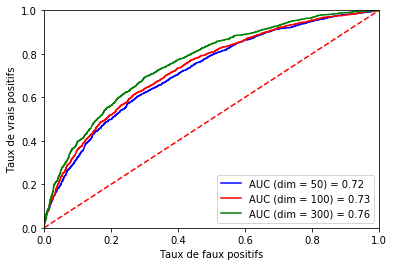

In [35]:
import matplotlib.pyplot as plt
plt.plot(fpr50_st, tpr50_st, 'b', label = 'AUC (dim = 50) = %0.2f' % roc_auc50_st)
plt.plot(fpr100_st, tpr100_st, 'r', label = 'AUC (dim = 100) = %0.2f' % roc_auc100_st)
plt.plot(fpr300_st, tpr300_st, 'g', label = 'AUC (dim = 300) = %0.2f' % roc_auc300_st)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

# Modèle pondéré

In [55]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
matrice_sentiments = {mot:(0,0) for mot in vocabulaire}
def sentiment_plus(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
def sentiment_moins(mot):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)  
for (score, tweet) in corpus_train:
    for mot in tweet.split():
        if score == 1:
            sentiment_plus(mot)
        else:
            sentiment_moins(mot)
            
matrice_sentiments_val = {mot:(matrice_sentiments[mot][0]-matrice_sentiments[mot][1])/((matrice_sentiments[mot][0]+matrice_sentiments[mot][1]))
                          for mot in vocabulaire}

In [56]:
def calcul_sentence_embedding_pond(phrase):
    if len(phrase)>0:
        sum1 = sum(matrice[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and
                   mot in vocabulaire)
        sum2 = sum(matrice["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
        return (sum1+sum2)/len(phrase)
    else:
        return matrice["lowfrequencyword"]
    
phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]
phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]

In [57]:
nom_dossier = 'ens'
dim = 50
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

In [59]:
phrases_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases]
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]
lr = LogisticRegression()
reg_log_50pond = lr.fit(X_train,Y_train)
Y_train_pred = reg_log_50pond.predict(X_train)

from sklearn import metrics
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

phrases_test_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log_50pond.predict(X_test)
# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

probs50pond = reg_log_50pond.predict_proba(X_test)
preds50pond = probs50pond[:,1]
fpr50pond, tpr50pond, threshold50pond = metrics.roc_curve(Y_test, preds50pond)
roc_auc50pond = metrics.auc(fpr50pond, tpr50pond)

0.78838
[[1393  591]
 [ 645 1353]]
0.6896032144650929


In [60]:
dim = 100
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

In [61]:
phrases_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases]
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]
lr = LogisticRegression()
reg_log_100pond = lr.fit(X_train,Y_train)
Y_train_pred = reg_log_100pond.predict(X_train)

from sklearn import metrics
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

phrases_test_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log_100pond.predict(X_test)
# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

probs100pond = reg_log_100pond.predict_proba(X_test)
preds100pond = probs100pond[:,1]
fpr100pond, tpr100pond, threshold100pond = metrics.roc_curve(Y_test, preds100pond)
roc_auc100pond = metrics.auc(fpr100pond, tpr100pond)

0.79722
[[1402  582]
 [ 652 1346]]
0.6901054746358614


In [65]:
dim = 300
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

In [66]:
phrases_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases]
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]
lr = LogisticRegression()
reg_log_300pond = lr.fit(X_train,Y_train)
Y_train_pred = reg_log_300pond.predict(X_train)

from sklearn import metrics
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

phrases_test_emb = [[score,calcul_sentence_embedding_pond(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log_300pond.predict(X_test)
# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

probs300pond = reg_log_300pond.predict_proba(X_test)
preds300pond = probs300pond[:,1]
fpr300pond, tpr300pond, threshold300pond = metrics.roc_curve(Y_test, preds300pond)
roc_auc300pond = metrics.auc(fpr300pond, tpr300pond)

C:\Users\torna\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.81416
[[1427  557]
 [ 597 1401]]
0.7101958814665997


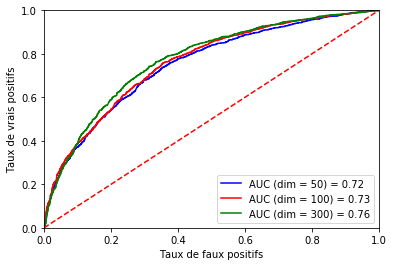

In [67]:
import matplotlib.pyplot as plt
plt.plot(fpr50pond, tpr50pond, 'b', label = 'AUC (dim = 50) = %0.2f' % roc_auc50_st)
plt.plot(fpr100pond, tpr100pond, 'r', label = 'AUC (dim = 100) = %0.2f' % roc_auc100_st)
plt.plot(fpr300pond, tpr300pond, 'g', label = 'AUC (dim = 300) = %0.2f' % roc_auc300_st)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.show()

In [68]:
# On sauve les modèles norm
with open("data/sentimental_analysis/reg_log_100pond.file", "wb") as f:
    pickle.dump(reg_log_100pond, f, pickle.HIGHEST_PROTOCOL)
with open("data/sentimental_analysis/reg_log_50pond.file", "wb") as f:
    pickle.dump(reg_log_50pond, f, pickle.HIGHEST_PROTOCOL)
with open("data/sentimental_analysis/reg_log_300pond.file", "wb") as f:
    pickle.dump(reg_log_100pond, f, pickle.HIGHEST_PROTOCOL)